In [67]:
# import torchvision.transforms.functional as Fu
from fastai.vision import *
from skimage.io import imread

%run losses.ipynb

%run Seg_dl.ipynb

In [2]:
p = Path('./Lea/190819')

In [3]:
def convert_to_float(x):
    if x.dtype == 'uint16':
        x = np.asarray(x/2**16, dtype = np.float32)
    else:
        x = np.asarray(x/1, dtype = np.float32)
    return x

In [4]:
pdd = (p/'DAPI').ls()
pdd[73]

PosixPath('Lea/190819/DAPI/20190625 Cas9-17 60x confocal TL_G04_s9_w1.TIF')

In [5]:
get_y_fn = lambda x: p/'masks'/f'{x.stem[:-2]}w2'
get_t_fn = lambda x: p/'Trans'/f'{x.stem[:-2]}w4.TIF'

In [6]:
def cropper(size:int, do_rand:bool=False, p:float=1.0):
    "Randomly zoom and/or crop."
    r = random.random()
    c = random.random()
    return crop(size = size, row_pct = r, col_pct = c)

In [7]:
tfms = [cropper(size=512, do_rand = True), 
        rand_zoom(scale=1)]
tfms

[RandTransform(tfm=TfmPixel (crop), kwargs={'size': 512, 'row_pct': 0.18749513937213336, 'col_pct': 0.7145490385546649}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': 1, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [8]:
data = (SegItemList.from_folder(p/'DAPI', extensions = '.TIF', recurse = False)
                            .split_by_rand_pct()
                            .label_from_func(get_y_fn, classes = np.array([0,1]))
                            .transform((tfms,tfms),tfm_y=True)
                            .databunch(bs = 6)
                            .normalize(([0.0262,0.23333],[0.0429,0.00634])))

In [9]:
data.train_ds

LabelList (432 items)
x: SegItemList
Image (2, 512, 512),Image (2, 512, 512),Image (2, 512, 512),Image (2, 512, 512),Image (2, 512, 512)
y: SegLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: Lea/190819/DAPI

In [10]:
learn = unet_learner(data, models.resnet18, pretrained=False,callback_fns = [ShowGraph, BnFreeze])

learn.model[0][0] = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
learn.model[10][0][0] = nn.Conv2d(98, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
learn.model[10][1][0] = nn.Conv2d(98, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
learn.model[11][0] = nn.Conv2d(98, 1, kernel_size=(1, 1), stride=(1, 1))
learn.model.cuda()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [11]:
fll = FocalLoss(alpha = 1., gamma = 0.2)

In [12]:
batch = data.one_batch(denorm = False)

X = batch[0]
Y = batch[1]
Y.min()

p_batch = learn.pred_batch(batch = (x.cuda() for x in batch))

In [13]:
Y.shape

torch.Size([6, 1, 512, 512])

In [14]:
fll(p_batch, Y)

tensor(1.2319)

In [17]:
dic(p_batch,Y)

tensor(0.9967)

In [76]:
learn.loss_func = fll

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


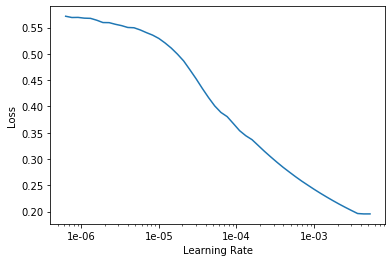

In [17]:
learn.lr_find()
learn.recorder.plot()

In [74]:
def dice_all(input, target):
    return dice(torch.sigmoid(input), target)

In [75]:
learn.metrics = [jac, dic, bcef, dice_all]

epoch,train_loss,valid_loss,jac,dic,bcef,dice_all,time
0,0.003959,0.004838,0.700745,0.680104,0.010516,0.814815,00:44


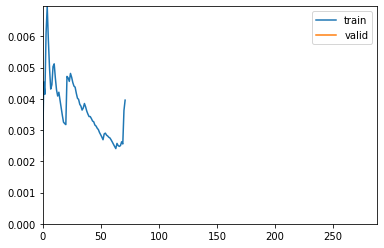

KeyboardInterrupt: 

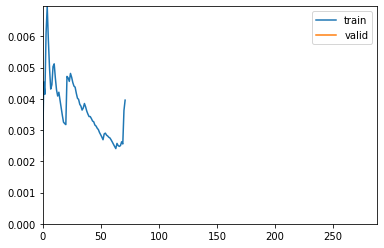

In [77]:
learn.fit_one_cycle(4,1e-03)

In [20]:
learn.loss_func = dic

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


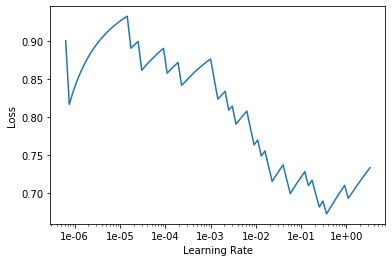

In [27]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,jac,dic,bcef,dice,time
0,0.351198,0.316473,0.425211,0.316473,0.008460,0.814815,00:47
1,0.343345,0.325246,0.435250,0.325246,0.008299,0.814815,00:47
2,0.300692,0.347678,0.457752,0.347678,0.004797,0.814815,00:47
3,0.293920,0.322889,0.431349,0.322889,0.007288,0.814815,00:46
4,0.345078,0.313677,0.422538,0.313677,0.006920,0.814815,00:46
5,0.346256,0.318572,0.426889,0.318572,0.007523,0.814815,00:46
6,0.332660,0.315185,0.422662,0.315185,0.006960,0.814815,00:46
7,0.369185,0.326067,0.434885,0.326067,0.006001,0.814815,00:46
8,0.353234,0.320984,0.429161,0.320984,0.008993,0.814815,00:46
9,0.351658,0.312129,0.419985,0.312129,0.007987,0.814815,00:45


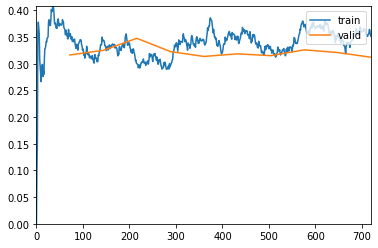

In [27]:
learn.fit_one_cycle(10,1e-06)

In [35]:
learn.save('dap_trans_nuc_seg_512_precrop_fll_then_dic_loss_031019')

In [24]:
learn.export()

In [68]:
learn = learn.load('dap_trans_nuc_seg_512_precrop_bce_then_dic_loss_200919')

In [40]:
# learn.callback_fns.append(BnFreeze)

In [49]:
dice(torch.sigmoid(p_batch),Y)

tensor(0.6667)

/home/chris/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()


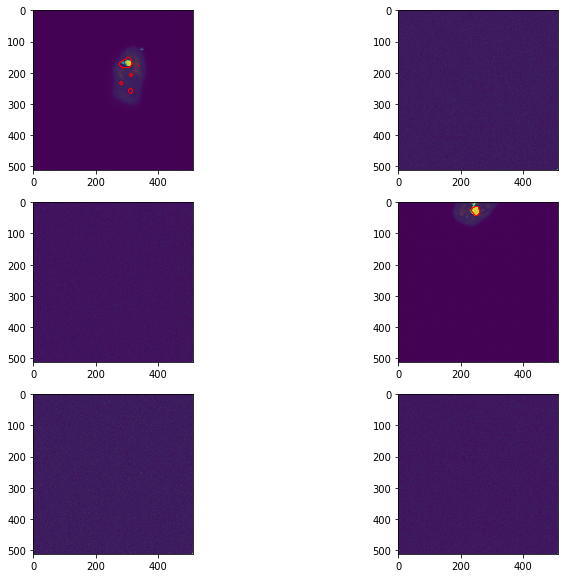

In [69]:
batch = data.one_batch(denorm = False)

X = batch[0]
Y = batch[1]
Y.min()

p_batch = learn.pred_batch(batch = (x.cuda() for x in batch))

p_batch_sig = torch.sigmoid(p_batch)

ind = 0
fig, ax = plt.subplots(3,2, figsize = (12,10))
for ind, a in enumerate(ax.flatten()):
    a.imshow(X[ind][0])
#     a.imshow(Y[ind][0], cmap = 'Blues', alpha = 0.5)
    a.contour(Y[ind][0], colors = 'r', linewidths = 0.4)
    a.imshow(p_batch_sig[ind][0], alpha = 0.8)

In [72]:
fll(p_batch,Y)

tensor(0.0016)

epoch,train_loss,valid_loss,jac,dic,bcef,dice,time
0,0.362616,0.314402,0.421027,0.314402,0.009524,0.814815,00:44
1,0.338323,0.311474,0.419522,0.311474,0.008448,0.814815,00:44
2,0.325228,0.341081,0.450656,0.341081,0.004515,0.814815,00:45
3,0.337018,0.326160,0.434987,0.326160,0.007094,0.814815,00:45
4,0.343764,0.334544,0.443251,0.334544,0.005144,0.814815,00:44
5,0.326126,0.331268,0.440903,0.331268,0.005366,0.814815,00:44
6,0.301594,0.337849,0.446779,0.337849,0.005024,0.814815,00:46
7,0.317647,0.334550,0.444030,0.334550,0.005733,0.814815,00:45
8,0.331610,0.357605,0.465862,0.357605,0.004337,0.814815,00:45
9,0.315811,0.315438,0.422848,0.315438,0.009006,0.814815,00:45


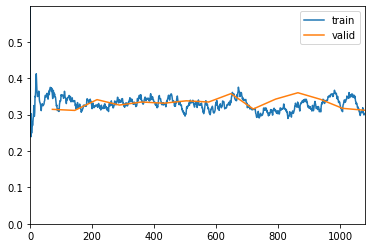

In [37]:
learn.unfreeze()
learn.fit_one_cycle(15, 1e-07)

In [64]:
learn.loss_func = weighted_dic

epoch,train_loss,valid_loss,jac,dic,bcef,dice,time
0,0.080816,0.001389,0.722222,0.720833,78.019791,0.814815,00:45
1,0.015596,0.001389,0.722222,0.720833,51.121532,0.814815,00:44
2,0.004359,0.001389,0.722222,0.720833,66.180283,0.814815,00:45


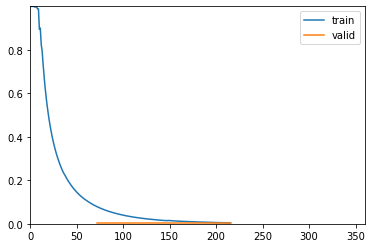

KeyboardInterrupt: 

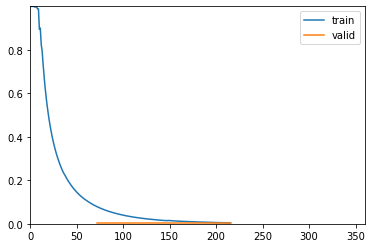

In [66]:
learn.fit_one_cycle(5, 1e-03)